# Final Project - Deep Learning Cancer Cell Detection

### Notebook by: Benjamin Pieczynski

In [1]:
# imports
import pandas as pd
import os
import shutil
import PIL
from PIL import Image, ImageOps
import numpy as np
import random

# plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# machine learning
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint # for saving our best model

2023-10-31 01:17:48.974233: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-31 01:17:49.005674: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-31 01:17:49.006809: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-31 01:17:49.637394: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Helper Functions

In [36]:
def image_info(img, idx):

    # Create a Matplotlib figure and axis for the plot
    fig, ax = plt.subplots()

    img = img[idx]

    # Display the image
    ax.imshow(img)

    # Set axis labels
    ax.set_xlabel("X Pixel Coordinate")
    ax.set_ylabel("Y Pixel Coordinate")

    # Show the plot
    plt.show()
    return

# histogram plot
def histo_plot(df,cname):
    plt.figure(figsize=(12, 6))

    sns.histplot(data=df, x=cname, hue=cname, element='step', common_norm=False, discrete=True)
    plt.title("Histogram of Legion Types")
    plt.xlabel("Legion Type")
    plt.ylabel("Count")

    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

    plt.tight_layout()
    plt.show()
    return

def evaluate_classes(class_dict, model, X_test, y_test):
    class_names = [class_dict[key] for key in class_dict]

    # confusion matrix for classification report
    y_pred = model.predict(X_test)

    # Match the prediction class to the highest prediction probability
    predicted_classes = [class_names[np.argmax(pred)] for pred in y_pred] # predicted value by the model
    actual_classes = [class_names[np.argmax(yval)] for yval in y_test] # actual value in the test data

    # initilize result dictionary to store results
    result_dict = {cname:{'total_pred':0, 'true_total':0, 'correct':0, 'incorrect':0,'false +':0, 'false -':0, 'false - %':0, 'false + %':0, 'total %':0} for cname in class_names} #[total, correct, incorrect, c/i accuracy]

    for key in result_dict:
        for i in range(len(predicted_classes)):
            cname = actual_classes[i] # correct classification name

            if predicted_classes[i] == key: # if the predicted class is equivalent to the current key
                result_dict[key]['total_pred']+=1
                if predicted_classes[i] == cname: # if the predicted class is the correct value
                    result_dict[key]['correct']+=1
                    result_dict[key]['true_total']+=1 # add one to the true total
                else: # the predicted value is not the correct value
                    result_dict[key]['false +']+=1
                    result_dict[key]['incorrect']+=1
            
            else:
                if cname == key:
                    result_dict[key]['true_total']+=1 # add one to the true total
                    result_dict[key]['false -']+=1 # a false negative has occured
                    result_dict[key]['incorrect']+=1

        # calculate % accuracy
        # our total accuracy is the correct predictions - false + and false - divided by the expected total from the training set
        result_dict[key]['total %'] = round(result_dict[key]['correct'] / (result_dict[key]['true_total'] + result_dict[key]['false +']) * 100,2)
        result_dict[key]['false - %'] = round((result_dict[key]['false -']) / result_dict[key]['total_pred'] * 100,2) # false negative rate
        result_dict[key]['false + %'] = round((result_dict[key]['false +']) / result_dict[key]['total_pred'] * 100,2) # false positive rate


    # Convert to DataFrame
    df = pd.DataFrame(result_dict).T  # Transpose to have class as the left most column

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = ['g','r','pink','orange']
    df[['correct', 'incorrect', 'false +', 'false -']].plot(kind='bar', color=colors, ax=ax)
    plt.title('Total Predictions')
    plt.xlabel('Classes')
    plt.ylabel('Count')
    plt.show()

    #fig, ax = plt.subplots(figsize=(10, 6))
    colors = ['g','r','orange']
    df[['total %', 'false + %', 'false - %']].plot(kind='bar', figsize=(10, 6))
    plt.title('Accuracy by Class')
    plt.xlabel('Classes')
    plt.ylabel('Accuracy (%)')
    plt.show()
    return df


def quick_eval(history, best_fname, X_test, y_test):
    
    # Load the best model
    best_model = tf.keras.models.load_model(best_fname)

    # plot
    plt.figure(figsize=(10,8))
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    #plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.xlabel('Epoch',fontsize=14)
    plt.ylabel('Accuracy',fontsize=14)
    plt.xlim()
    plt.ylim()
    plt.grid()
    plt.legend(loc='lower right', fontsize=14)

    # Load the best model
    best_model = tf.keras.models.load_model(best_fname)

    # further evaluation
    test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
    print(f'Test loss: {test_loss}')
    print(f'Test accuracy: {test_accuracy}')

    return best_model


## Dataset

### TensorFlow Dataset: colorectal_histology

"Multi-class texture analysis in colorectal cancer histology" - Kather et al. 2016

In [3]:
# reading in the dataset
data, data_info = tfds.load('colorectal_histology', split='train', shuffle_files=True, as_supervised=True, with_info=True, download=True)
assert isinstance(data, tf.data.Dataset)

2023-10-31 01:17:57.189704: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-31 01:17:57.190059: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


### Preprocessing

In [37]:
# take images and lables and place them into numpy arrays
X = []
y = []

# iterate through dataset
for file in tfds.as_numpy(data):
    image, name = file[0], file[1]
    X.append(image)
    y.append(name)

# convert to numpy arrays
X = np.array(X).reshape(-1, 150,150,3) # reshape to required shape
y = np.array(y)

print('Image array size: ', X.shape,'\nlabel array size:' , y.shape)

Image array size:  (5000, 150, 150, 3) 
label array size: (5000,)


In [38]:
class_dict = {0:'tumor', 1:'stroma', 2:'complex', 3:'lympho', 
              4:'debris', 5:'mucosa', 6:'adipose', 7:'empty'}

feature_list = [class_dict[key] for key in class_dict]
feature_list

['tumor',
 'stroma',
 'complex',
 'lympho',
 'debris',
 'mucosa',
 'adipose',
 'empty']

Opening multiple images for examination

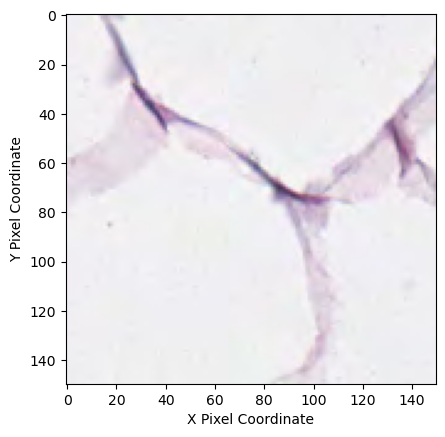

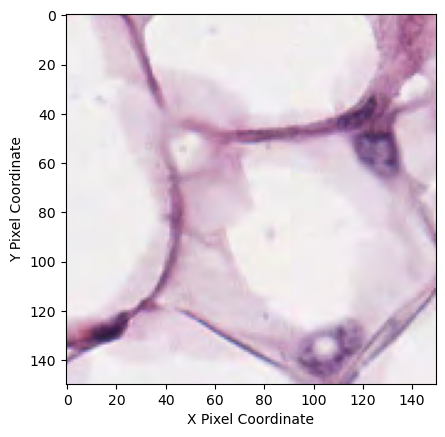

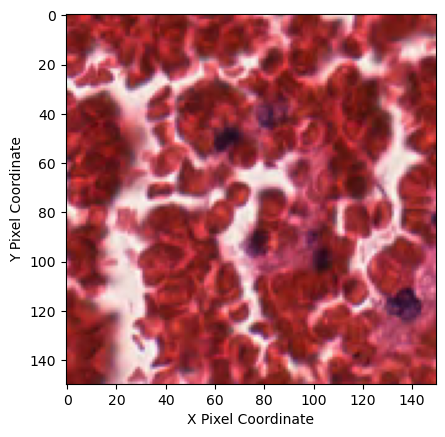

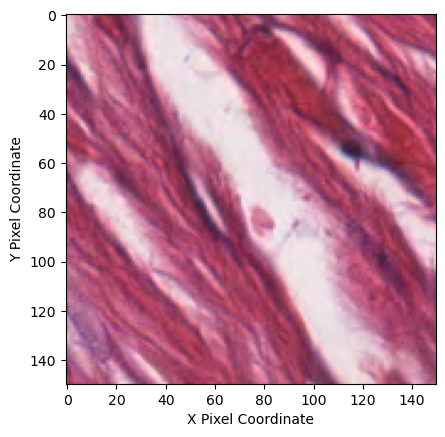

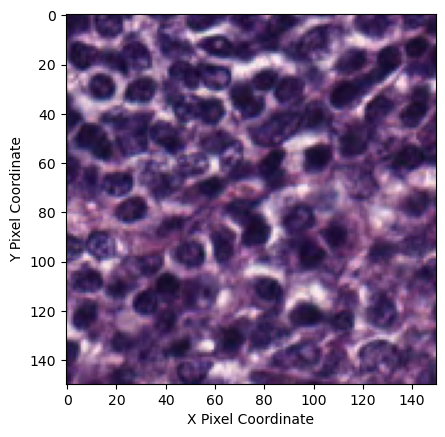

In [6]:
for n in range(5,10):
    image_info(X,n)

Looking at the number of unique values for different features

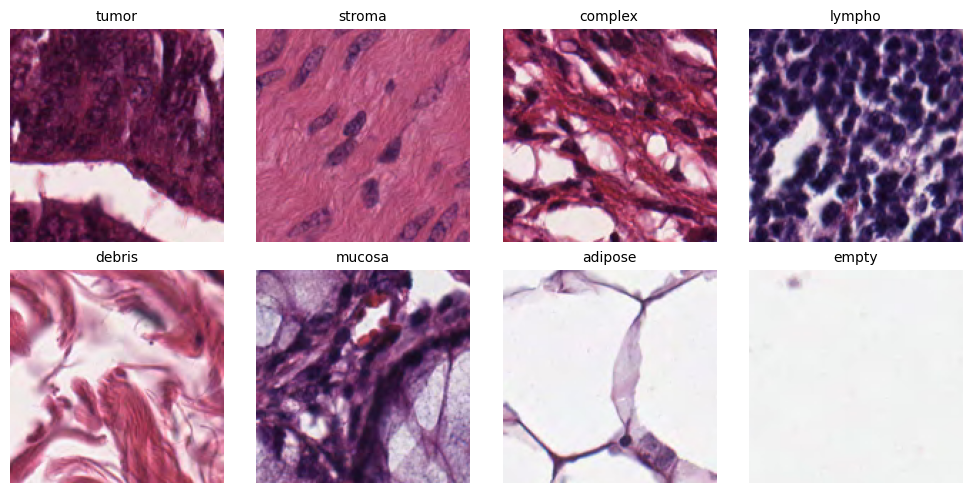

In [7]:
# iterate through unique values and plot them in an image
plt.figure(figsize=(10,5))
for key in class_dict:
    ctype = class_dict[key]
    w = y==key
    temp_y = y[w]
    temp_X = X[w]
    random_index = random.randint(0, len(temp_y))
    random_img = temp_X[random_index]

    # Load the image
    #img = Image.open(random_img)

    # Create a subplot for the current 'dx' value
    list_len = len(class_dict)
    plt.subplot(2, list_len//2+list_len%2, list(feature_list).index(ctype) + 1)
    
    # Display the image
    plt.imshow(random_img)
    plt.axis('off')  # Turn off axis labels
    
    # Add 'dx' label above the image
    plt.title(ctype,fontsize=10)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

We need to check for class imbalance. We will create a dataframe to plot a histogram of each label.

In [8]:
# building a data frame for each label
temp_arr = []
for label in y:
    temp_arr.append(class_dict[label])

df = pd.DataFrame(np.array(temp_arr),columns=['ctype'])
df

,ctype
0,debris
1,mucosa
2,mucosa
3,tumor
4,adipose
...,...
4995,tumor
4996,stroma
4997,mucosa
4998,debris


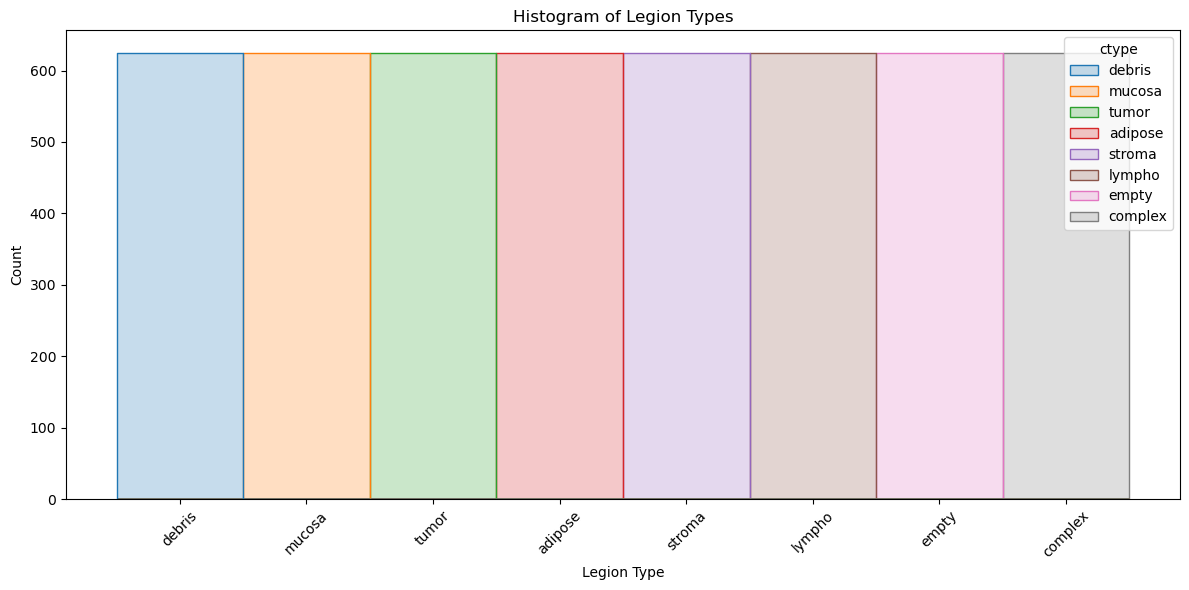

In [9]:
histo_plot(df,'ctype')

Our dataset is balanced, so we do not need to worry about class balance.

### Train test split

Building Dataset for the CNN

In [10]:
X.shape

(5000, 150, 150, 3)

In [39]:
# Define the sizes for train, validation, and test sets
train_size = int(len(X) * 0.8)
test_size = int(len(X) * 0.2)

# Create the train, validation, and test sets using array slicing
X_train = X[:train_size]
X_test = X[train_size:train_size+test_size]

# labels
y_train = y[:train_size]
y_test = y[train_size:train_size+test_size]

# Print the sizes of the datasets
print(f'Train data shape: {X_train.shape}, Train labels shape: {y_train.shape}')
print(f'Test data shape: {X_test.shape}, Test labels shape: {y_test.shape}')

# normalize the training and testing data / scaling
scaler = MinMaxScaler()
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# one-hot encoding for labels
y_train = tf.one_hot(y_train, depth=8, axis=-1)
y_test = tf.one_hot(y_test, depth=8, axis=-1)


Train data shape: (4000, 150, 150, 3), Train labels shape: (4000,)
Test data shape: (1000, 150, 150, 3), Test labels shape: (1000,)


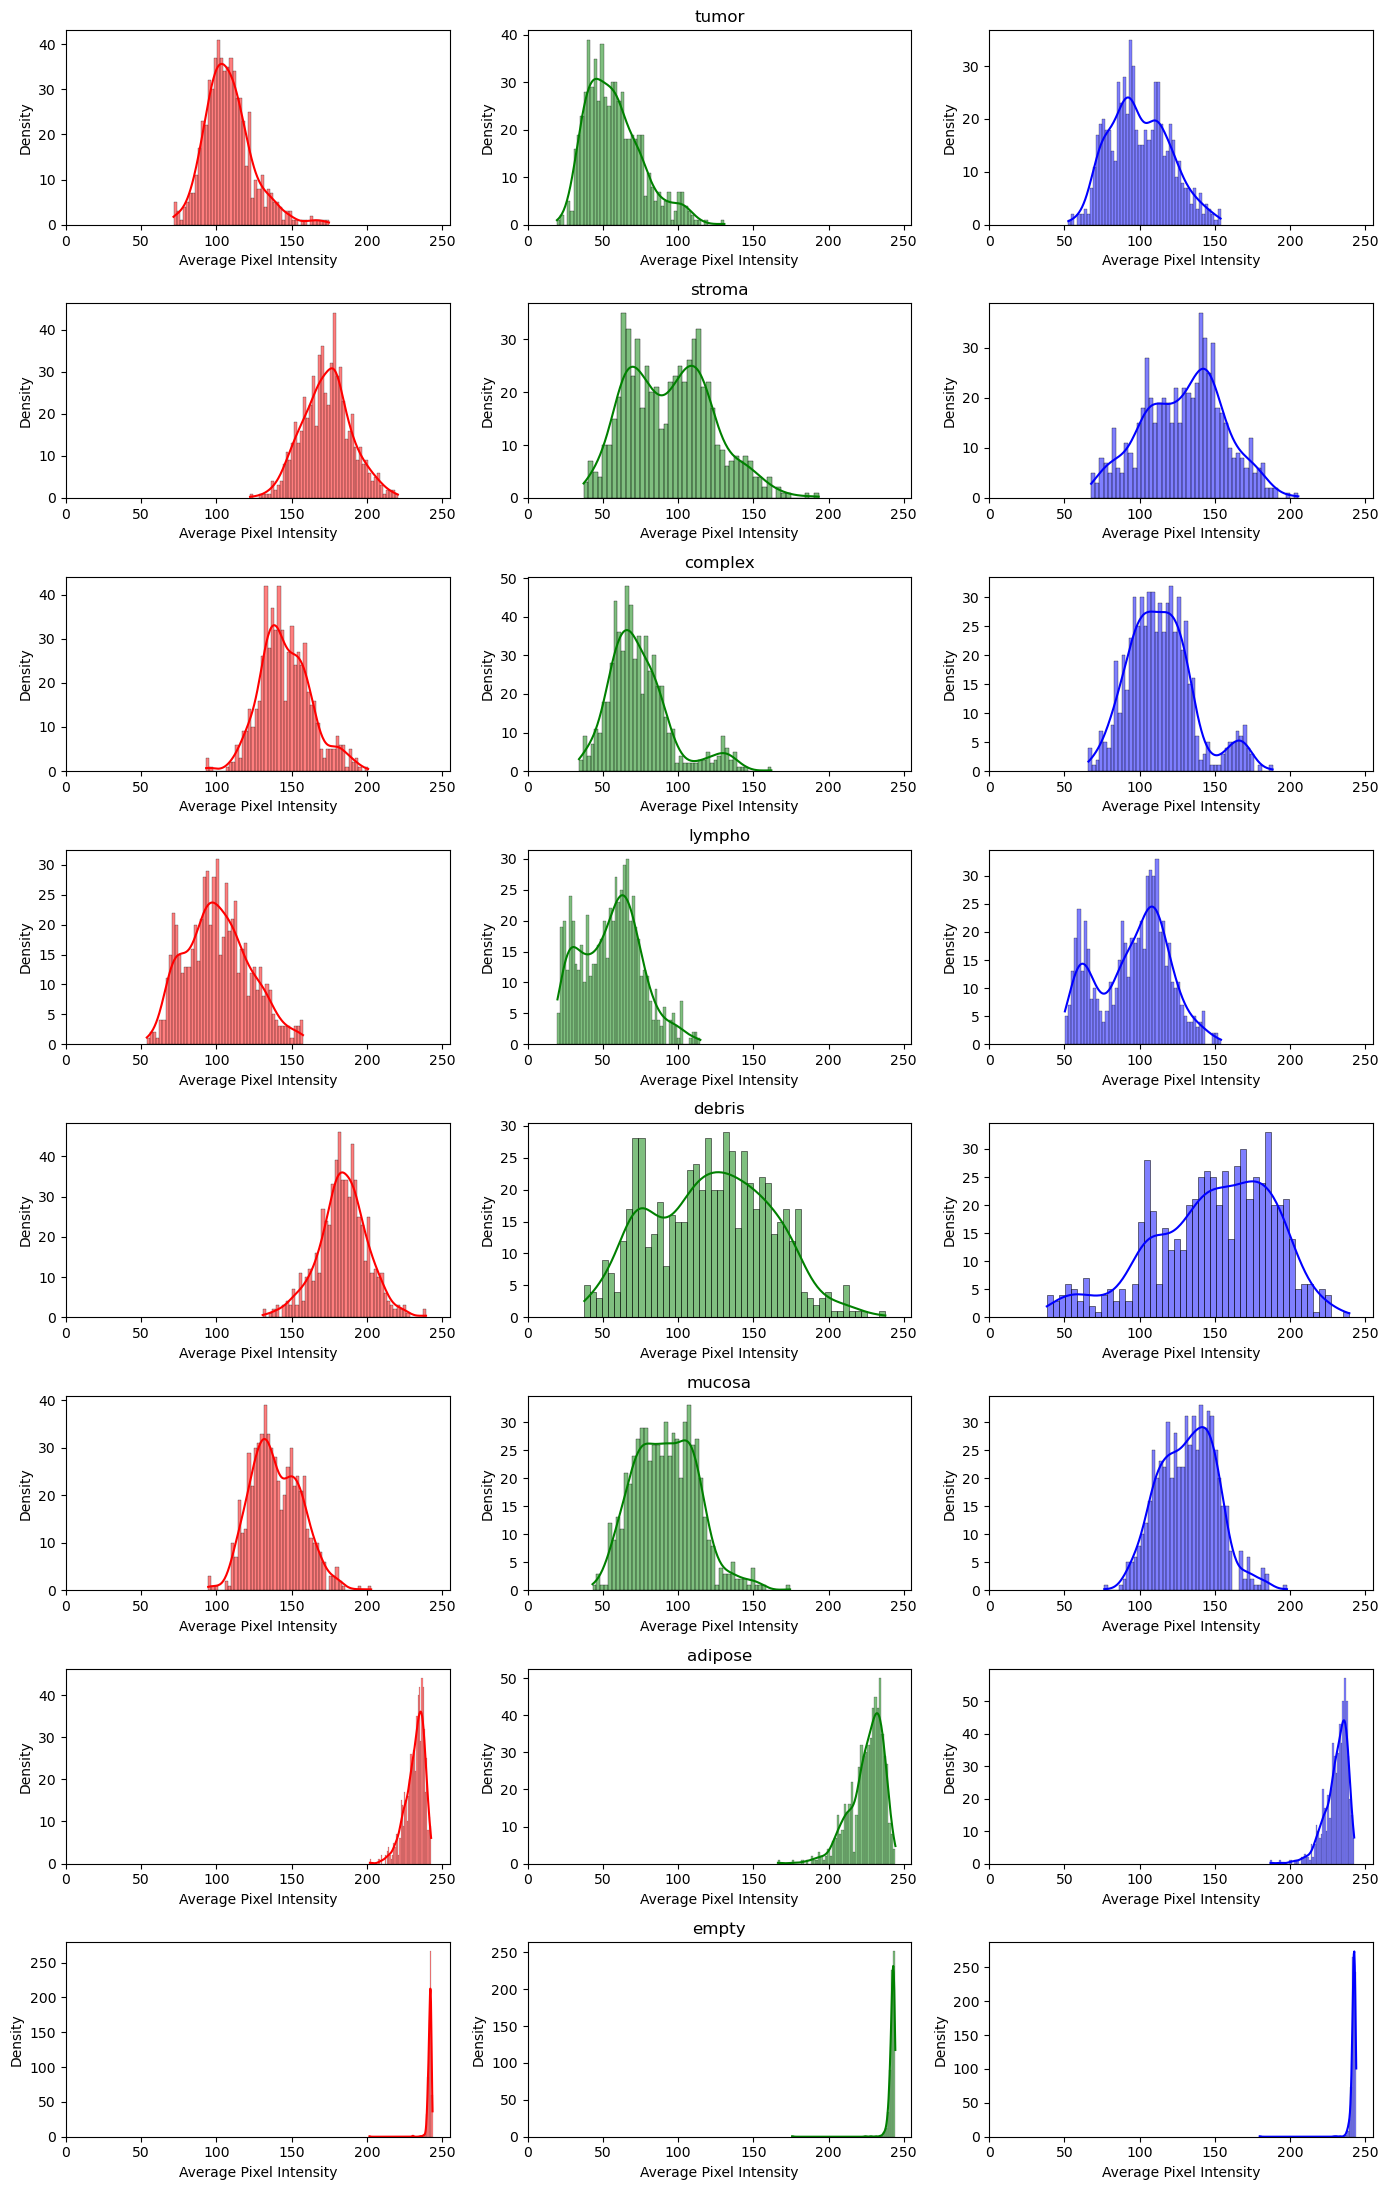

In [12]:
# Calculate average pixel intensity for each class and each color channel
unique_classes = np.unique(y)
color_channels = ['red', 'green', 'blue']

fig, axes = plt.subplots(len(unique_classes), len(color_channels), figsize=(14, 22), sharex=False)

for i, class_label in enumerate(unique_classes):
    class_indices = np.where(y == class_label)[0]
    class_images = X[class_indices]  # Images for the current class
    
    for j, color_channel in enumerate(color_channels):
        channel_idx = {'red': 0, 'green': 1, 'blue': 2}[color_channel]
        class_intensity = np.mean(class_images[:, :, :, channel_idx], axis=(1, 2))  # Calculate average intensity for each image in the class
        
        ax = axes[i, j]
        # Set x-axis ticks and limits
        ax.set_xlim(0, 255)  # Assuming pixel intensities are in the [0, 255] range
        ax.set_xticks(np.arange(0, 256, 50))  # Adjust tick locations as needed

        sns.histplot(class_intensity, bins=50, kde=True, ax=ax, color=color_channel, label=color_channel)
        if j==1:
            ax.set_title(f'{class_dict[int(class_label)]}')
        ax.set_xlabel('Average Pixel Intensity')
        ax.set_ylabel('Density')
        
plt.tight_layout()
plt.show()

# CNN Model

In [13]:
# image specification and # of epochs
img_width=150
img_height=150
epochs=15
X.shape

(5000, 150, 150, 3)

In [14]:
# CNN architecture
model = Sequential()

# CONV L1
model.add(Conv2D(24, (3,3), 1, activation='relu',input_shape=(img_width, img_height, 3)))
model.add(MaxPooling2D())

# CONV L2
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

# CONV L3
model.add(Conv2D(24, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

# Flattening Layer
model.add(Flatten())

# Dense Layers
model.add(Dense(200, activation='relu'))
model.add(Dense(8, activation='softmax'))
 

In [15]:
# model summary
model.summary()

# Define the learning rate variable
learning_rate = tf.Variable(0.001, trainable=False)

# During training, update the learning rate as needed
tf.keras.backend.set_value(learning_rate, 1e-4)

# compile the model
model.compile('adam',loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

# name of the best model
best_fname = 'standard_best_model.h5'

# Add ModelCheckpoint callback during training
checkpoint = ModelCheckpoint(filepath=best_fname, monitor='val_accuracy', save_best_only=True, verbose=1)

# fit the model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_test, y_test), callbacks=[checkpoint])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 24)      672       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 24)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        6944      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 24)        6936      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 24)        0

/home/bpieczynski/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


125/125 [==============================] - ETA: 0s - loss: 0.1871 - accuracy: 0.6555
Epoch 2: val_accuracy improved from 0.64700 to 0.67500, saving model to standard_best_model.h5
125/125 [==============================] - 19s 149ms/step - loss: 0.1871 - accuracy: 0.6555 - val_loss: 0.1729 - val_accuracy: 0.6750
Epoch 3/15
125/125 [==============================] - ETA: 0s - loss: 0.1595 - accuracy: 0.7255
Epoch 3: val_accuracy improved from 0.67500 to 0.74900, saving model to standard_best_model.h5
125/125 [==============================] - 18s 146ms/step - loss: 0.1595 - accuracy: 0.7255 - val_loss: 0.1620 - val_accuracy: 0.7490
Epoch 4/15
125/125 [==============================] - ETA: 0s - loss: 0.1366 - accuracy: 0.7800
Epoch 4: val_accuracy did not improve from 0.74900
125/125 [==============================] - 18s 148ms/step - loss: 0.1366 - accuracy: 0.7800 - val_loss: 0.1464 - val_accuracy: 0.7420
Epoch 5/15
125/125 [==============================] - ETA: 0s - loss: 0.1380 - a

32/32 [==============================] - 1s 28ms/step - loss: 0.1753 - accuracy: 0.8050
Test loss: 0.17532667517662048
Test accuracy: 0.8050000071525574
32/32 [==============================] - 1s 28ms/step


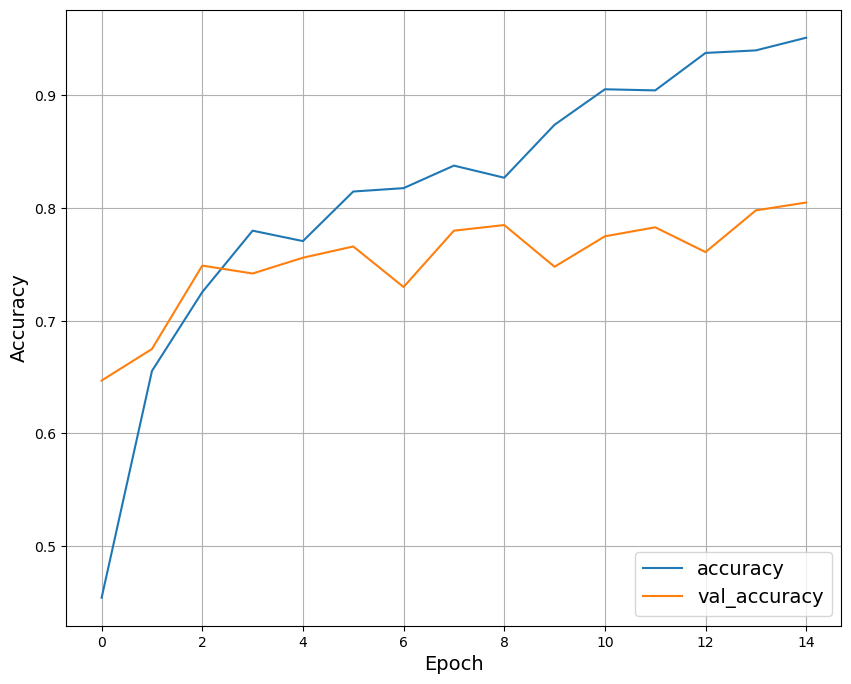

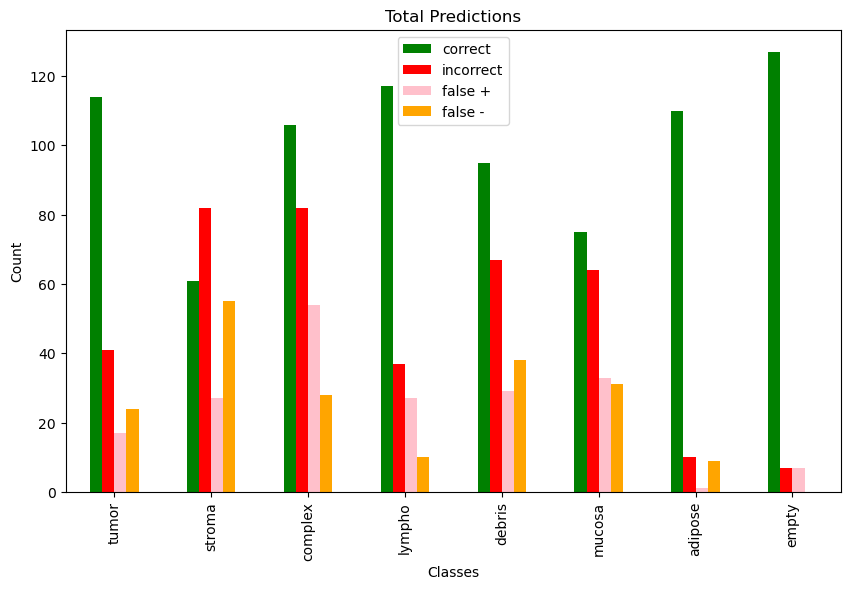

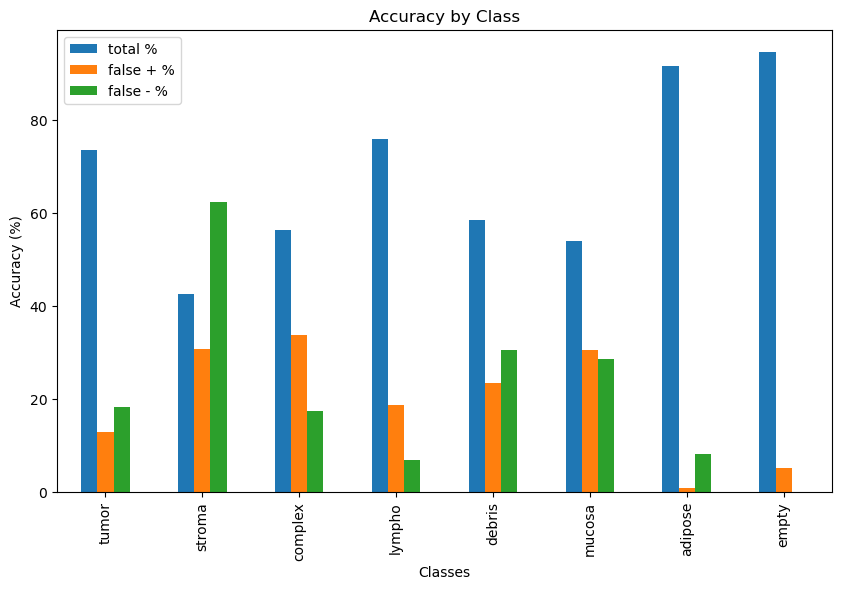

,total_pred,true_total,correct,incorrect,false +,false -,false - %,false + %,total %
tumor,131.0,138.0,114.0,41.0,17.0,24.0,18.32,12.98,73.55
stroma,88.0,116.0,61.0,82.0,27.0,55.0,62.50,30.68,42.66
complex,160.0,134.0,106.0,82.0,54.0,28.0,17.50,33.75,56.38
lympho,144.0,127.0,117.0,37.0,27.0,10.0,6.94,18.75,75.97
debris,124.0,133.0,95.0,67.0,29.0,38.0,30.65,23.39,58.64
mucosa,108.0,106.0,75.0,64.0,33.0,31.0,28.70,30.56,53.96
adipose,111.0,119.0,110.0,10.0,1.0,9.0,8.11,0.90,91.67
empty,134.0,127.0,127.0,7.0,7.0,0.0,0.00,5.22,94.78


In [26]:
# evaluation
best_model = quick_eval(history, best_fname, X_test, y_test)
res = evaluate_classes(class_dict, best_model, X_test, y_test)
res

## DATA AUGMENTATION

In [27]:
num_augmented_samples = 4000 # number of augmented images to include in the training set

# one hot encoding for y
y = tf.one_hot(y, depth=8, axis=-1) # for data augmentation

# Random data augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Randomly select images for augmentation
selected_indices = random.sample(range(len(X)), num_augmented_samples)

# Generate augmented images and labels
X_augmented = []
y_augmented = []

for idx in selected_indices:
    img = np.expand_dims(X[idx], 0)
    label = y[idx]

    augmented = datagen.flow(img, batch_size=32)
    X_augmented.append(augmented[0][0])
    y_augmented.append(label)

# Convert the lists to numpy arrays
X_augmented = np.array(X_augmented)
y_augmented = np.array(y_augmented)

# Combining the augmented dataset and the original dataset
X_train_aug = np.concatenate((X_train, X_augmented), axis=0)
y_train_aug = np.concatenate((y_train, y_augmented), axis=0)

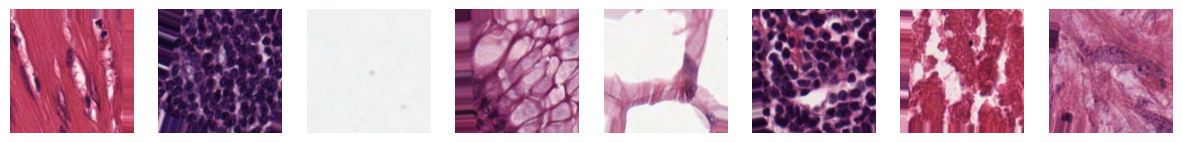

In [28]:
# Select a few random images and their corresponding labels
num_images_to_display = 8
random_indices = random.sample(range(len(X_augmented)), num_images_to_display)

# Create a figure with subplots
fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 5))

# Display the selected images and their labels
for i, idx in enumerate(random_indices):
    axes[i].imshow(X_augmented[idx]/255)  # Rescale to [0, 1]
    #axes[i].set_title(f"Label: {y_augmented[idx]}")
    axes[i].axis('off')

plt.show()

In [29]:
# CNN architecture
model = Sequential()

# CONV L1
model.add(Conv2D(24, (3,3), 1, activation='relu',input_shape=(img_width, img_height, 3)))
model.add(MaxPooling2D())

# CONV L2
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

# CONV L3
model.add(Conv2D(24, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

# Flattening Layer
model.add(Flatten())

# Dense Layers
model.add(Dense(200, activation='relu'))
model.add(Dense(8, activation='softmax'))


## Training the augmented model
# model summary
model.summary()

# Define the learning rate variable
learning_rate = tf.Variable(0.001, trainable=False)

# During training, update the learning rate as needed
tf.keras.backend.set_value(learning_rate, 1e-4)

# compile the model
model.compile('adam',loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

# name of the best model
best_fname = 'augmentation_best_model.h5'

# Add ModelCheckpoint callback during training
checkpoint = ModelCheckpoint(filepath=best_fname, monitor='val_accuracy', save_best_only=True, verbose=1)

# fit the model
history = model.fit(X_train_aug, y_train_aug, epochs=epochs, batch_size=32, validation_data=(X_test, y_test), callbacks=[checkpoint])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 24)      672       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 74, 74, 24)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 32)        6944      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 24)        6936      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 17, 17, 24)       

2023-10-31 01:32:26.754082: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2160000000 exceeds 10% of free system memory.


250/250 [==============================] - ETA: 0s - loss: 0.8550 - accuracy: 0.3805
Epoch 1: val_accuracy improved from -inf to 0.54300, saving model to augmentation_best_model.h5
250/250 [==============================] - 38s 151ms/step - loss: 0.8550 - accuracy: 0.3805 - val_loss: 0.2513 - val_accuracy: 0.5430
Epoch 2/15
  1/250 [..............................] - ETA: 38s - loss: 0.3476 - accuracy: 0.5000

/home/bpieczynski/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


250/250 [==============================] - ETA: 0s - loss: 0.2686 - accuracy: 0.5311
Epoch 2: val_accuracy improved from 0.54300 to 0.62000, saving model to augmentation_best_model.h5
250/250 [==============================] - 37s 147ms/step - loss: 0.2686 - accuracy: 0.5311 - val_loss: 0.1961 - val_accuracy: 0.6200
Epoch 3/15
250/250 [==============================] - ETA: 0s - loss: 0.2115 - accuracy: 0.6127
Epoch 3: val_accuracy improved from 0.62000 to 0.72300, saving model to augmentation_best_model.h5
250/250 [==============================] - 36s 144ms/step - loss: 0.2115 - accuracy: 0.6127 - val_loss: 0.1717 - val_accuracy: 0.7230
Epoch 4/15
250/250 [==============================] - ETA: 0s - loss: 0.1780 - accuracy: 0.6933
Epoch 4: val_accuracy did not improve from 0.72300
250/250 [==============================] - 37s 146ms/step - loss: 0.1780 - accuracy: 0.6933 - val_loss: 0.1646 - val_accuracy: 0.6980
Epoch 5/15
250/250 [==============================] - ETA: 0s - loss: 0.

32/32 [==============================] - 1s 29ms/step - loss: 0.1310 - accuracy: 0.7970
Test loss: 0.13095241785049438
Test accuracy: 0.796999990940094
32/32 [==============================] - 1s 27ms/step


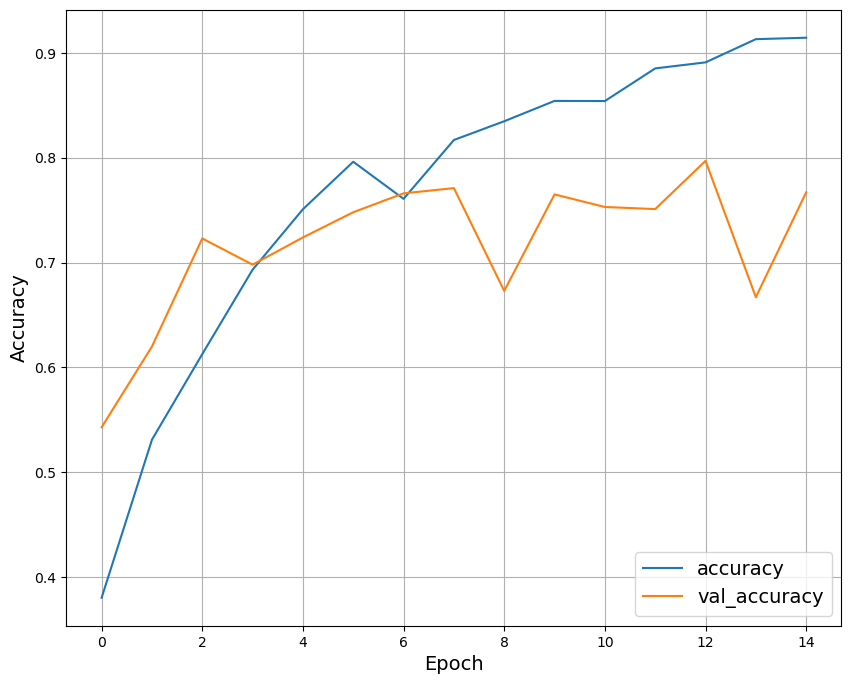

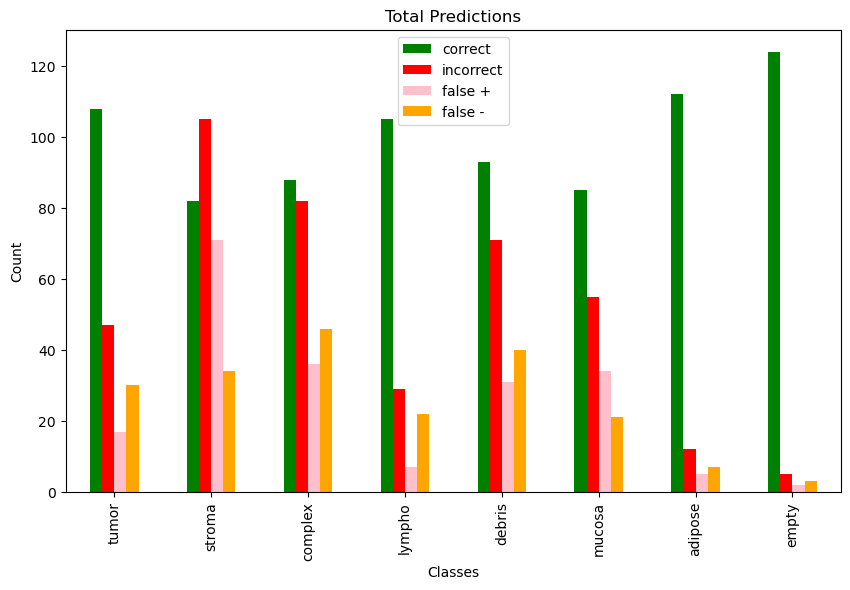

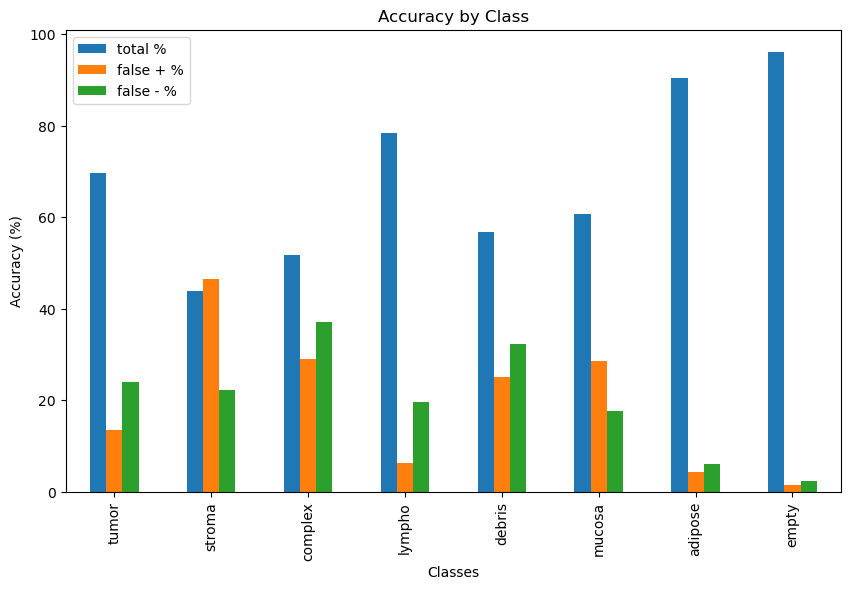

In [30]:
# evaluation
best_model = quick_eval(history, best_fname, X_test, y_test)
res = evaluate_classes(class_dict, best_model, X_test, y_test)

### Transfer Learning

Our model has a decent fit to the data, but we should be able to improce it much further. We will use transfer learning with the Inception-V3 pre-trained model.

In [31]:
# import the inception-V3 model
from tensorflow.keras.applications.inception_v3 import InceptionV3

Setup

In [32]:
# get the pre-trained model
inception_model = InceptionV3(input_shape=(img_width, img_height, 3),
                                include_top = False, # leave out the last layer
                                weights = 'imagenet') # pre-training on imagenet

# Pre-processing function for InceptionV3
preprocess_input = tf.keras.applications.inception_v3.preprocess_input

inception_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d_6[0][0]']            
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalizati

In [40]:
# make all layers non-trainable (may make lower layer trainable to increase performance, but this could risk overfitting)
for layer in inception_model.layers[:-10]: # freeze everything except the last 10 layers
    layer.trainable = False

# add custom layers to the top of the model
x = inception_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(8, activation='softmax')(x)  # Replace num_classes with the number of your classes

# Create the model
model = Model(inputs=inception_model.input, outputs=predictions)

# Define the learning rate variable
learning_rate = tf.Variable(0.001, trainable=False)

# During training, update the learning rate as needed
tf.keras.backend.set_value(learning_rate, 0.1)

# compile model
model.compile('adam',loss='binary_crossentropy', metrics=['accuracy'])

# name of the best model
best_fname = 'transfer_best_model.h5'

# Add ModelCheckpoint callback during training
checkpoint = ModelCheckpoint(filepath=best_fname, monitor='val_accuracy', save_best_only=True, verbose=1)

# fit the model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_test, y_test), callbacks=[checkpoint])

Epoch 1/15
125/125 [==============================] - ETA: 0s - loss: 0.1900 - accuracy: 0.7538
Epoch 1: val_accuracy improved from -inf to 0.83900, saving model to transfer_best_model.h5


/home/bpieczynski/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


125/125 [==============================] - 24s 172ms/step - loss: 0.1900 - accuracy: 0.7538 - val_loss: 0.1139 - val_accuracy: 0.8390
Epoch 2/15
125/125 [==============================] - ETA: 0s - loss: 0.0917 - accuracy: 0.8790
Epoch 2: val_accuracy improved from 0.83900 to 0.85600, saving model to transfer_best_model.h5
125/125 [==============================] - 20s 161ms/step - loss: 0.0917 - accuracy: 0.8790 - val_loss: 0.1042 - val_accuracy: 0.8560
Epoch 3/15
125/125 [==============================] - ETA: 0s - loss: 0.0660 - accuracy: 0.9095
Epoch 3: val_accuracy improved from 0.85600 to 0.85800, saving model to transfer_best_model.h5
125/125 [==============================] - 20s 159ms/step - loss: 0.0660 - accuracy: 0.9095 - val_loss: 0.1029 - val_accuracy: 0.8580
Epoch 4/15
125/125 [==============================] - ETA: 0s - loss: 0.0518 - accuracy: 0.9280
Epoch 4: val_accuracy improved from 0.85800 to 0.86700, saving model to transfer_best_model.h5
125/125 [================

32/32 [==============================] - 5s 121ms/step - loss: 0.1163 - accuracy: 0.8830
Test loss: 0.11629582196474075
Test accuracy: 0.8830000162124634
32/32 [==============================] - 4s 116ms/step


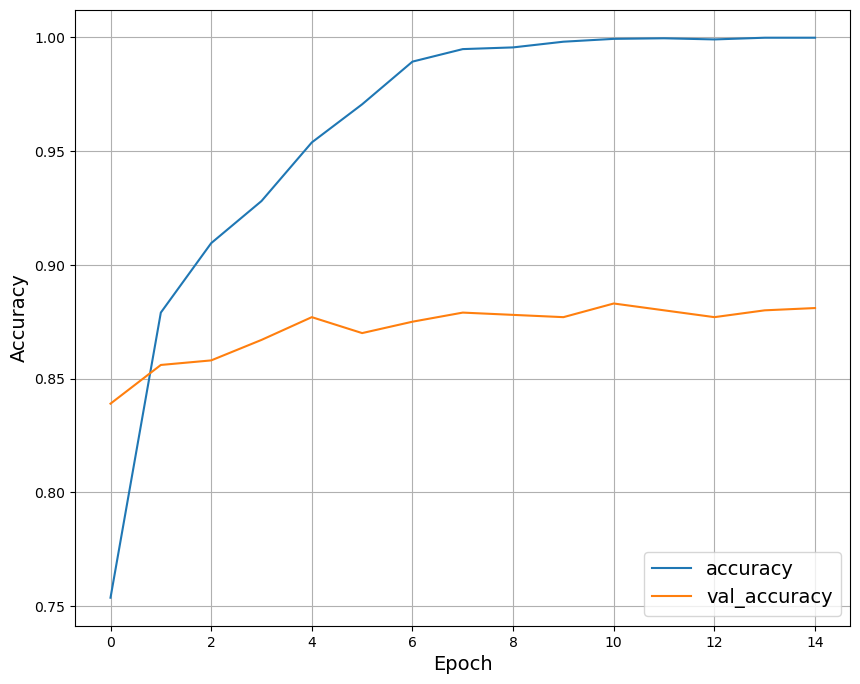

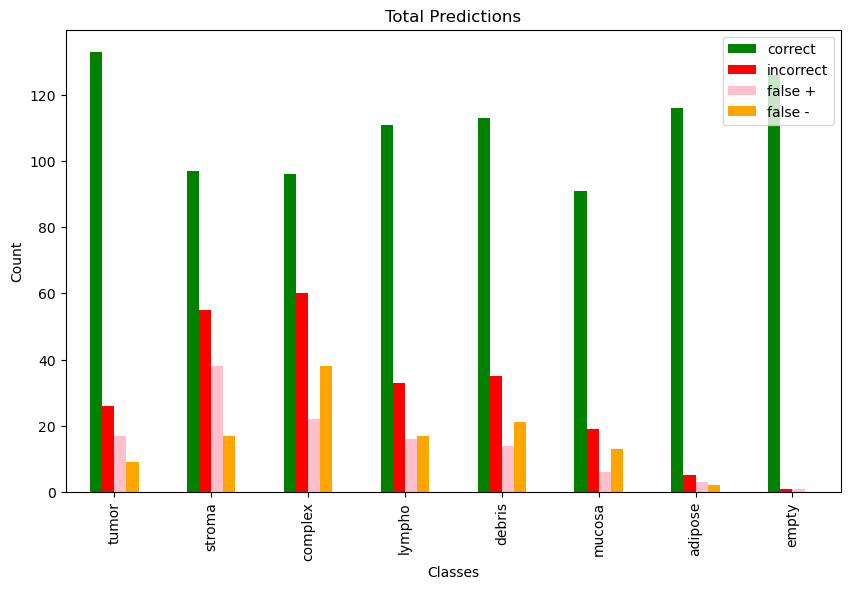

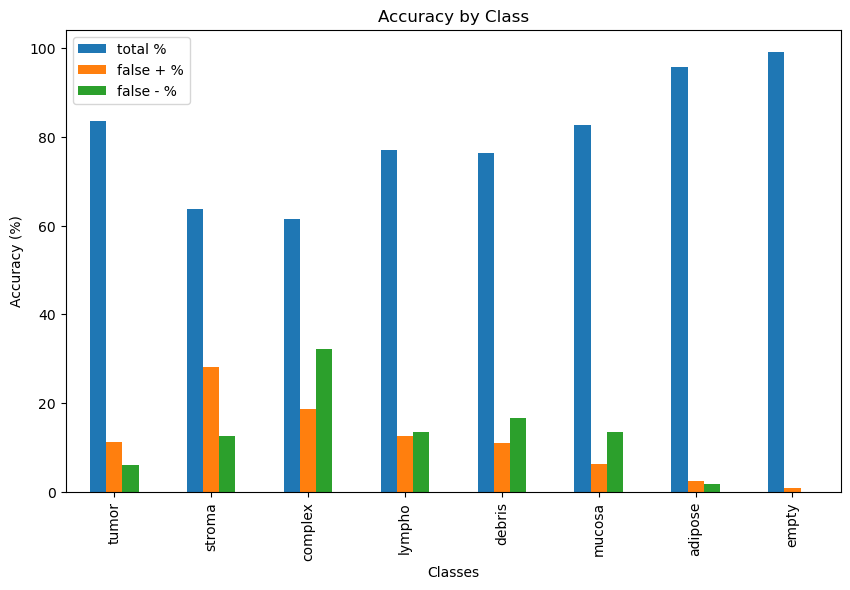

In [41]:
# evaluation
best_model = quick_eval(history, best_fname, X_test, y_test)
res = evaluate_classes(class_dict, best_model, X_test, y_test)